# Keyrir Strætó of hratt?: Samanburður keyrsluhraðagagna frá Strætó API-inu við hámarkshraðagögn

_**Árni Dagur Guðmundsson**: arni@dagur.eu | Menntaskólinn við Hamrahlíð_

## Inngangur:

### Open Street Map

### API
Falið í kóða heimasíðu Strætó má finna API (forritaskil) sem geyma ýmsar upplýsingar um staka strætisvagna í rauntíma. Strætó appið notar þetta API meðal annars til að sýna staðsetningu strætisvagna á korti. Ég bjó til einfaldan Python pakka sem kallar á API-ið og spýtir út niðurstöðunum í JSON. Hér fyrir neðan sést niðurstaða einfalds kalls:

In [1]:
from straeto import api
api.getBusPositionsFor(["1", "55"])[0]

{'deviceNumber': 112,
 'gpsFix': 2,
 'gpsTime': '180519182015',
 'heading': 319.57,
 'lastStop': 14001500,
 'lat': 64.0678666666667,
 'lon': -21.9574833333333,
 'nextStop': 14001501,
 'pingCode': 6,
 'route': '1-C',
 'routeNumber': '1',
 'speed': 0.0}

Eins og sést býður API-ið upp á breiddargráðu (_lat_), og lengdargráðu (_lon_). Því er til dæmis hægt að birta staðsetningu allra strætisvagna landsins á kort líkt og svo:

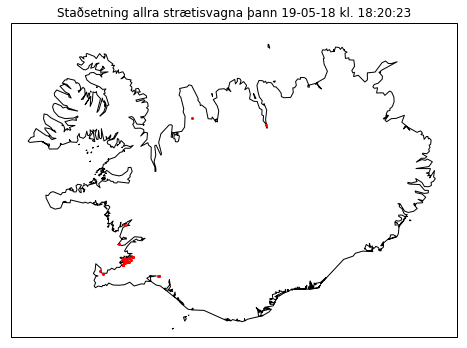

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from datetime import datetime
from straeto import straeto

fig, ax = straeto.get_map(region='iceland')

for bus in api.getAllBusPositions():
    plt.plot(bus['lon'], bus['lat'], marker='o', color='red', markersize=2,
             transform=ccrs.Geodetic())

plt.title('Staðsetning allra strætisvagna þann {}'.format(datetime.now().strftime('%d-%m-%y kl. %H:%M:%S')))
plt.show()

Hraðinn er einnig til staðar en ekki vitum við þó hvaða mælieining notuð er til þess að mæla hann.

$k\cdot v_{api} = v \Rightarrow k = \frac{v}{v_{api}}$

In [3]:
from straeto import straeto
bdict, p_bdict = straeto.getConsecutiveBuses(ratio=0.5)

print(len(bdict),len(p_bdict))

33 33


In [4]:
from geopy.distance import geodesic
from datetime import datetime as dt
G = []
B = []
Ks = []
for key in bdict:
    bus = bdict[key]; p_bus = p_bdict[key]
    t_1 = dt.strptime(bus['gpsTime'],"%y%m%d%H%M%S"); t_2 = dt.strptime(p_bus['gpsTime'],"%y%m%d%H%M%S")
    delta_t = (t_1-t_2).total_seconds()
    delta_s = geodesic((bus['lat'], bus['lon']), (p_bus['lat'], p_bus['lon'])).km

    kmh = (delta_s/delta_t)*3600
    avg_speed = (1/2)*(bus['speed']+p_bus['speed'])

    k = kmh/avg_speed
    Ks.append(k)
    dic = {
        'speed_0': p_bus['speed'],
        'speed_1': bus['speed'],
        'delta_s': delta_s,
        'delta_t': delta_t,
        'kmh': kmh,
        'avg_speed': avg_speed,
        'route': bus['route'],
        'k': k
    }
    if 1.7 < k < 1.9:
        G.append(dic)
    else:
        B.append(dic)

print('Good:')
for i in G:
    print('{} | k = {} / {} = {} | {} --> {}'.format(
        i['route'], round(i['kmh'], 2), round(i['avg_speed'], 2), round(i['k'], 2), i['speed_0'], i['speed_1']
    ))
print('Bad:')
for i in B:
    print('{} | k = {} / {} = {} | {} --> {}'.format(
        i['route'], round(i['kmh'], 2), round(i['avg_speed'], 2), round(i['k'], 2), i['speed_0'], i['speed_1']
    ))
avg_k = sum(Ks)/len(Ks)
print(avg_k)


Good:
18-D | k = 50.35 / 27.92 = 1.8 | 30.31 --> 25.54
12-A | k = 27.31 / 15.19 = 1.8 | 15.98 --> 14.39
5-C | k = 39.11 / 21.13 = 1.85 | 19.73 --> 22.54
36-A | k = 54.4 / 29.5 = 1.84 | 30.03 --> 28.96
57-A | k = 87.95 / 47.73 = 1.84 | 47.32 --> 48.13
1-E | k = 26.5 / 14.68 = 1.8 | 17.02 --> 12.35
24-C | k = 32.77 / 17.74 = 1.85 | 23.33 --> 12.15
15-B | k = 51.4 / 27.41 = 1.87 | 27.27 --> 27.56
2-B | k = 59.47 / 31.57 = 1.88 | 30.54 --> 32.6
35-A | k = 20.81 / 11.4 = 1.83 | 12.94 --> 9.86
17-A | k = 41.98 / 22.2 = 1.89 | 22.6 --> 21.8
15-A | k = 45.53 / 26.54 = 1.72 | 27.17 --> 25.9
A6 | k = 45.24 / 24.59 = 1.84 | 24.53 --> 24.66
55-A | k = 82.53 / 44.61 = 1.85 | 49.89 --> 39.32
Bad:
28-A | k = 25.41 / 13.11 = 1.94 | 15.39 --> 10.82
11-B | k = 23.28 / 11.92 = 1.95 | 8.07 --> 15.77
12-B | k = 33.6 / 11.91 = 2.82 | 5.53 --> 18.28
15-D | k = 26.17 / 16.05 = 1.63 | 18.61 --> 13.48
6-B | k = 35.37 / 21.55 = 1.64 | 18.31 --> 24.78
13-A | k = 44.08 / 21.73 = 2.03 | 24.02 --> 19.43
4-B | k = 28

## Undirbúningur gagna:

```
ALTER TABLE buses ADD COLUMN geom Geometry(Point, 4326);
```
```
UPDATE buses SET geom=ST_SetSrid(ST_MakePoint(lon, lat), 4326);
```

```
ALTER TABLE buses ADD maxspeed integer;
```
```
UPDATE buses b SET maxspeed = (SELECT r.maxspeed FROM roads r ORDER BY b.geom <-> r.geom LIMIT 1);
```

Not working:

```
SELECT r.maxspeed FROM roads r, buses b WHERE ST_DWithin(b.geom, r.geom, 8) ORDER BY ST_Distance(r.geom, b.geom);
```

In [5]:
!psql straeto -c "\dt"

            List of relations
 Schema |      Name       | Type  | Owner 
--------+-----------------+-------+-------
 public | roads           | table | arni
 public | spatial_ref_sys | table | arni
(2 rows)

